# NLMFE in practice

This notebook aims at introducing the nlmfe package implementing the FPMLE and FPMLE$^{++}$ algorithms developed in Mugnier and Wang (2022, WP).

In [1]:
from nlmfe.TwoWayFPMLE import TwoWayFPMLE
from nlmfe.BiasCorrections import BiasCorrections

import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
help(TwoWayFPMLE)

Help on class TwoWayFPMLE in module nlmfe.TwoWayFPMLE:

class TwoWayFPMLE(builtins.object)
 |  TwoWayFPMLE(A, b, indiv_ref=0, het_exog=None, model='logit', max_workers=4, solver='Newton-CG', options_set={'xtol': 1e-06, 'maxiter': 1000, 'disp': False}, verbose=True)
 |  
 |  TwoWayFPMLE:
 |      This class implements fast Gauss-Seidel fixed-point algorithms (FPMLE 
 |      and FPMLE++) for estimating semiparametric nonlinear panel data models 
 |      with two-way fixed effects as described in Mugnier & Wang (2022, 
 |      Working Paper) -- ``Identification and (Fast) Estimation of Large 
 |      Nonlinear Panel Models with Two-Way Fixed Effects''. 
 |      The implementation is as described in the paper. Notation attempts to 
 |      follow that used in the paper. 
 |      In particular: 
 |      `N'  : number of individuals;
 |      `T'  : number of time periods (must be balanced);
 |      `K'  : number of observed covariates.
 |      Missing cells in unbalanced panel data can be imp

## Application to simulated data

In [2]:
def logit_cdf(x):
    """
    logit_cdf:
        evaluate the logistic cumulative distribution function (cdf) at point x.
        
    :param x: evaluation point
    """
    return 1. / (1. + np.exp(-x))

def logit_pdf(x):
    """
    logit_pdf:
        evaluate the logistic probability density function (pdf) at point x.
        
    :param x: evaluation point
    """
    return np.exp(x) / (1. + np.exp(x))**2

We simulate a simple binary logit model 500 times: 

$y_{it} \in \{0,1\}$ and for all $i\in\{1,...,N\}, t\in\{1,...,T\}$:

\begin{equation}
Pr(y_{it} =1|x_{it}, \alpha_i, \xi_t) = 1/(1+\exp(-(x_{it}\beta + \alpha_i + \xi_t)))
\end{equation}

with $\beta=1$, $\alpha_1=0$, $\alpha_i \overset{iid}{\sim}\mathcal N(0,1/16)$ for $i\geq 2$, $\xi_t \overset{iid}{\sim}\mathcal N(0,1/16)$, and $x_{it} = v_{it} + \alpha_i$, $v_{it}\overset{iid}{\sim}$Unif$[-\sqrt{3},\sqrt{3}]$. The $\alpha_i, \xi_t,v_{it}$ are mutually independent. We set $N,T=200$.

In [3]:
seed = 2022
np.random.seed(seed)

B = 500
n, T = 200, 200
beta = np.ones(1)
alpha = np.random.normal(0, 1/4, size=(B,n)) # indiv FEs
alpha[:,0] = 0 # normalization 
xi = np.random.normal(0, 1/4, size=(B,T)) # time FEs
X = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(B,n,T,len(beta))) + alpha[:,:,None,None]  # correlated effect
M = X.dot(beta) + alpha[:,:,None] + xi[:,None,:]
Y = (np.random.uniform(size=(B,n,T)) <= logit_cdf(M)).astype(int)
ape = beta*np.mean(logit_pdf(M), axis=(1,2))   

We estimate the homogeneous slope coefficient ($\beta$), individual-specific effects ($\alpha_i$) and time-specific effects ($\xi_t$) with FPMLE++.

In [4]:
res_bet = np.empty((B,1))
res_alpha = np.empty((B,n-1))
res_xi = np.empty((B,T))
res_ape = np.empty((B,1))

for b in tqdm(range(B)):
    logit_model = TwoWayFPMLE(X[b], Y[b], model='logit', verbose=False)
    res_bet[b], res_alpha[b], res_xi[b] = logit_model.fit(fast=True, hess=True, iter_max=2) # set fast=False to use FPMLE
    res_ape[b] = res_bet[b]*np.mean(logit_pdf(X[b].dot(res_bet[b]) + np.insert(res_alpha[b], 0, 0)[:,None] + res_xi[b][None,:]))

100%|████████████████████████████████████████| 500/500 [00:03<00:00, 125.75it/s]


In [5]:
print('True beta: ', beta[0])
print('Average bias beta_hat: ', np.mean(res_bet-beta))
print('Average RMSE beta_hat: ', np.mean(np.abs(res_bet-beta)))
print('Average true average partial effect (APE): ', np.mean(ape))
print('Average bias APE_hat: ', np.mean(res_ape-ape))
print('Average RMSE APE_hat: ', np.mean(np.abs(res_ape-ape)))

True beta:  1.0
Average bias beta_hat:  -0.004794109327612266
Average RMSE beta_hat:  0.010150062045055513
Average true average partial effect (APE):  0.19419937001920265
Average bias APE_hat:  -0.0019422556896525403
Average RMSE APE_hat:  0.0022028635393134145


In [6]:
# compute analytically bias corrected estimates and standard errors (see Fernandez-Val and Weidner, 2016)
res_bet_BC = np.empty((B, 3))

for b in tqdm(range(B)):
    biascorrect = BiasCorrections(X[b], Y[b], model='logit')
    res_bet_BC[b,0], avar = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=0)
    res_bet_BC[b,1], _ = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=1)
    res_bet_BC[b,2], _ = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=2)

100%|█████████████████████████████████████████| 500/500 [00:35<00:00, 14.17it/s]


In [7]:
# compare bias, RMSE, and coverage of analytical 95% CI 
table = np.empty((5, 3))
table[:] = np.nan
table[0, 0] = np.nanmean(res_bet-beta)
table[1, 0] = np.nanmean(res_ape-ape)
table[2, 0] = np.nanmean(res_bet_BC[:,0]-beta)
table[3, 0] = np.nanmean(res_bet_BC[:,1]-beta)
table[4, 0] = np.nanmean(res_bet_BC[:,2]-beta)

table[0, 1] = np.nanmean(np.abs(res_bet-beta))
table[1, 1] = np.nanmean(np.abs(res_ape-ape))
table[2, 1] = np.nanmean(np.abs(res_bet_BC[:,0]-beta))
table[3, 1] = np.nanmean(np.abs(res_bet_BC[:,1]-beta))
table[4, 1] = np.nanmean(np.abs(res_bet_BC[:,2]-beta))


table[0, 2] = np.mean(np.abs(res_bet-beta))/ np.sqrt(avar/(n*T)) 
table[1, 2] = np.nan # not yet available in the package
table[2, 2] = np.mean((np.abs(res_bet_BC[:,0]-beta) / np.sqrt(avar/(n*T)) <= norm.ppf(1-0.05/2)))
table[3, 2] = np.mean((np.abs(res_bet_BC[:,1]-beta) / np.sqrt(avar/(n*T)) <= norm.ppf(1-0.05/2)))
table[4, 2] = np.mean((np.abs(res_bet_BC[:,2]-beta) / np.sqrt(avar/(n*T)) <= norm.ppf(1-0.05/2)))

res = pd.DataFrame(table)
res.columns = ['Bias', 'RMSE', 'Coverage (.95)']
res.index = ['beta', 'average partial effect (APE)', 'beta_corrected (L=0)', 'beta_corrected (L=1)', 'beta_corrected (L=2)']

print(res)
print(' ')
print('True beta: ', beta[0])
print('Average true APE: ', np.mean(ape))

                                  Bias      RMSE  Coverage (.95)
beta                         -0.004794  0.010150        0.817747
average partial effect (APE) -0.001942  0.002203             NaN
beta_corrected (L=0)          0.005611  0.010615        0.932000
beta_corrected (L=1)          0.005541  0.010590        0.934000
beta_corrected (L=2)          0.005536  0.010590        0.934000
 
True beta:  1.0
Average true APE:  0.19419937001920265


## Application to real data (selection into international trade)
Helpman et al. (2008) estimate trade flows and explicitly take into account firm selection into export markets. Their method features a first step that estimates the establishment of exportation from one country to another using a binary model. Because of this step, they can then control for the fraction of firms that export (consistently estimated from the first step) and the selection effect due to zero trade flows when estimating the gravity equation in the second step. In the empirical application, this first step is implemented as following (see their equation 12 on page 455):

\begin{equation}
	\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi\left(-\gamma\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j\right), i,j=1,...,N, i \neq j, \qquad (1)
\end{equation}

where $T_{ij}=1$ when country $j$ exports to $i$ and zero otherwise, $\text{dist}_{ij}$ is the distance between $i$ and $j$, $\phi_{ij}$ is a vector of observed country-pair specific variables, $\zeta_i$ ($\xi_j$) is an importer (exporter) fixed effect, and $\Phi$ is the standard normal cumulative distribution function. According to their theoretical model,  $\gamma$ is interpreted as a constant elasticity of a firm's trade with respect to distance. 


Different from the original setting, we allow  $\gamma$ to be country- and exporter-specific:

\begin{equation}
	\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi(-\gamma^{\text{exp}}_j\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j), i,j=1,...,N, i \neq j. \qquad (2)
\end{equation}

Recent literature on international trade raises concerns about the assumption of constant trade elasticities that impose homogeneous effects of trade cost shifters (see Carrère et al. (2020); Chen and Novy (2021) for examples). The specification in (2) relaxes this assumption along two dimensions. First, it  allows firms from different countries to react differently to the same change in trade cost shifters when exporting to the same third country. Second, two countries in a trade relationship, when exporting to the other, can react differently to the same change in the trade cost shifters that affects the trade in both directions. Furthermore, this specification is implied by a theoretical model along the lines of Helpman et al. (2008) with demand elasticity in the product market being  country-specific. *[Concretely, denote by $\varepsilon_j$ the demand elasticity in country $j$ in their equation 2 on page 449. Then, the log of trade cost,* $\ln \tau_{ij}$*, enters the first (and the second) step with a coefficient $\varepsilon_j-1$. As a result, along the lines of their empirical specification, we can specify* $(\varepsilon_j-1)\ln\tau_{ij}=\gamma_j^{\text{exp}}d_{ij}-u_{ij}$*.]* 

We also consider another specification that allows   $\gamma$ to be country- and importer-specific:

\begin{equation}
		\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi(-\gamma^{\text{imp}}_i\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j), i,j=1,...,N, i \neq j. \qquad (3)
\end{equation}

Similar to (2), the specification in (3) allows two countries in a trade relationship to react differently to the same change in the trade cost shifters that affects the trade in both directions. Moreover, (3) can also incorporate firm's heterogeneous reaction to the same change in trade cost shifters, depending on the country it exports to.  

In what follows, we estimate the first step of the method by Helpman et al. (2008) using  (2) and (3), and quantify the extent to which the trade elasticity is heterogeneous among countries.

### Data

In [8]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [9]:
import wget
import zipfile as zf

# import Helpman et al. (2008) data
url = 'https://scholar.harvard.edu/files/melitz/files/gravity_data_share.zip'
wget.download(url)
files = zf.ZipFile('gravity_data_share.zip','r')
files.extractall()
files.close()

100% [......................................................] 1532500 / 1532500

In [10]:
# read data
data = pd.read_stata('data1980s_share.dta', convert_dates=False, convert_categoricals=False, preserve_dtypes=True)

# keep if year==1986
data = data[data['year']==1986]

# drop CONGO as exporter because it did not export to any country in 1986
data = data[data['expcode']!=141780]

# create trade dummy 
data['trade'] = (data['ln_trade'].isna()==False).astype(float) 

data.head()

,year,expcode,impcode,common_lang,legalsystem_same,religion_same,religion_same_recoded,border,cu,ln_distance,fta,ln_trade,colonial,gatt_wto,n_islands,n_landlock,trade
5,1986,117100,130120,0,0,0.013403,0.013403,0,0,4.106691,0,6.761573,0,1,0,0,1.0
17,1986,117100,134340,1,0,0.012962,0.013351,0,0,3.997316,0,NaN,0,1,0,0,0.0
22,1986,117100,135040,0,0,0.013130,0.013130,0,0,4.212758,0,8.024535,0,1,0,0,1.0
30,1986,117100,137320,0,0,0.013000,0.013000,0,0,3.991379,0,NaN,0,1,0,0,0.0
49,1986,117100,137360,1,1,0.014067,0.014456,0,0,3.793402,0,NaN,0,1,0,0,0.0


In [11]:
print(len(np.unique(data['expcode'])))
print(len(np.unique(data['impcode'])))

157
158


### Estimate exporter-specific effects

In [12]:
# sort columns and convert data to numeric
data = data[['expcode', 'impcode', 'ln_distance', 'border', 'n_islands', 'n_landlock', 'legalsystem_same','common_lang', 
             'colonial', 'cu', 'fta', 'religion_same', 'trade']]
for j in data.columns[2:]:
    data[j] = pd.to_numeric(data[j])

# nlmfe need some preprocessing of the data into N x T x K panel structure
from nlmfe.PanelPreProcess import PanelPreProcess
PanelPreProcess = PanelPreProcess()
data = data.sort_values(['expcode', 'impcode'])
Xexp, yexp, exp_ids, _ = PanelPreProcess.reshape_MaR(np.array(data)[:,:-1],  np.array(data)[:,-1], 0, 1)

In [13]:
# estimate exporter-specific distance effects 
# normalize exporter fixed effect by first alphabetic country: AFGHANISTAN  (see https://www23.statcan.gc.ca/imdb-bmdi/pub/document/2201_DLI_D7_T22_V1-fra.pdf)
AFG = np.where(exp_ids==450040)[0]

probit_model = TwoWayFPMLE(Xexp, yexp, indiv_ref=AFG, het_exog=[0], model='probit')
beta_exp, alpha_exp, xi_exp = probit_model.fit(fast=True, hess=True, iter_max=2)
marginal_effect_at_mean_exp = np.mean(beta_exp[:,0])*norm.pdf(np.nanmean(np.einsum('ijk,ik->ij', Xexp, beta_exp) 
                + np.insert(alpha_exp, AFG, 0)[:,None] + xi_exp[None,:]))
average_partial_effect_exp = np.nanmean(beta_exp[:,0].reshape(len(exp_ids))[:,None]*norm.pdf(
                np.einsum('ijk,ik->ij', Xexp, beta_exp)  + np.insert(alpha_exp, AFG, 0)[:,None] + xi_exp[None,:]))

Mixed heterogeneous and homogeneous slopes model.


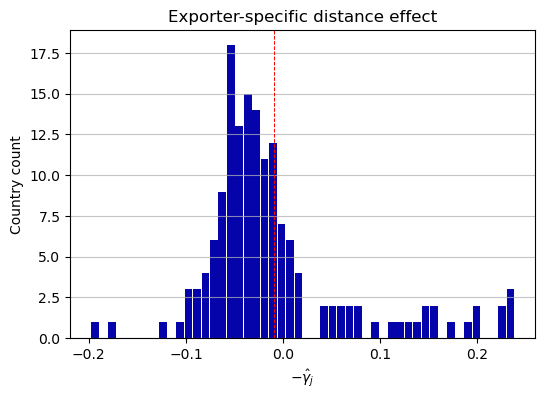

In [14]:
# histogram of heterogeneous effects
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize = (6,4))
plt.axvline(x=np.mean(beta_exp[:,0]), color='red', linestyle='--', linewidth=0.7)
plt.hist(beta_exp[:,0], bins=50, rwidth=0.9, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Country count')
plt.xlabel(r'$-\hat \gamma_{j}$')
plt.title('Exporter-specific distance effect')
plt.show()

In [15]:
print(np.round([np.mean(beta_exp[:,0]), marginal_effect_at_mean_exp, average_partial_effect_exp], 4))

[-0.0096 -0.0038 -0.0048]


*Note that these results do not exactly match that in the paper probably because of Jupyter's notebook rounding errors*.

### Estimate importer-specific effects

In [16]:
# estimate importer-specific distance effects 
from nlmfe.PanelPreProcess import PanelPreProcess
PanelPreProcess = PanelPreProcess()
data = data.sort_values(['impcode', 'expcode'])
Ximp, yimp, imp_ids, _ = PanelPreProcess.reshape_MaR(np.array(data)[:,:-1], np.array(data)[:,-1], 1, 0)

prob_mod = TwoWayFPMLE(Ximp, yimp, AFG, [0], model='probit')
beta_imp, alpha_imp, xi_imp = prob_mod.fit(fast=True, hess=True, iter_max=2)
marginal_effect_at_mean_imp = np.mean(beta_imp[:,0])*norm.pdf(np.nanmean(np.einsum('ijk,ik->ij', Ximp, beta_imp) 
                                + np.insert(alpha_imp, AFG, 0)[:,None] + xi_imp[None,:]))
average_partial_effect_imp = np.nanmean(beta_imp[:,0].reshape(len(imp_ids))[:,None]*norm.pdf(np.einsum('ijk,ik->ij', 
                                Ximp, beta_imp) + np.insert(alpha_imp, AFG, 0)[:,None] + xi_imp[None,:]))

Mixed heterogeneous and homogeneous slopes model.


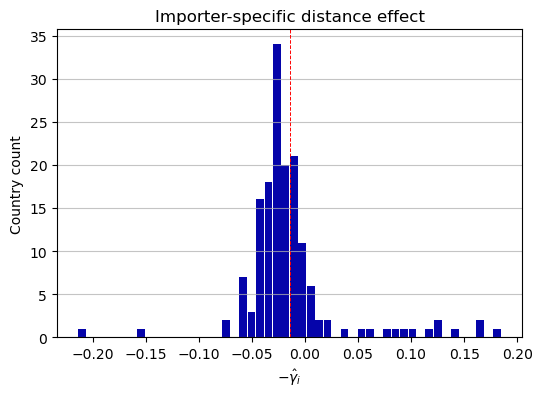

In [17]:
# histogram of heterogeneous effects
fig, ax = plt.subplots(figsize = (6,4))
plt.axvline(x=np.mean(beta_imp[:,0]), color='red', linestyle='--', linewidth=0.7)
plt.hist(beta_imp[:,0], bins=50, rwidth=0.9, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Country count')
plt.xlabel(r'$-\hat \gamma_{i}$')
plt.title('Importer-specific distance effect')
plt.show()

In [18]:
print(np.mean(beta_imp[:,0]))
print(marginal_effect_at_mean_imp)
print(average_partial_effect_imp)

-0.01434621481776957
-0.005708598291670138
-0.003932018561511836


*Again, these results do not match exactly that in the paper probably because of Jupyter's rounding errors.*

### Percentile bootstrap (symmetric) CIs for standard deviation

In [19]:
# compute percentile bootstrap (symmetric) CIs for standard deviation 
np.random.seed(2022) # replicability
B = 500
bs_samples_exp = np.random.choice(range(len(exp_ids)), size=(B, len(exp_ids)))
bs_samples_imp = np.random.choice(range(len(imp_ids)), size=(B, len(imp_ids)))
beta_res_exp = np.zeros((B, len(exp_ids), 1))
beta_res_imp = np.zeros((B, len(imp_ids), 1))

for b in tqdm(range(B)):
    prob_mod_exp = TwoWayFPMLE(Xexp[bs_samples_exp[b]], yexp[bs_samples_exp[b]], 0, [0], model='probit', verbose=False)
    beta_exp, _, _ = prob_mod_exp.fit(fast=True, hess=True, nu=1e-9, eps=1e-4, iter_max=2)
    beta_res_exp[b,:, 0] = beta_exp[:,0]
    prob_mod_imp = TwoWayFPMLE(Ximp[bs_samples_imp[b]], yimp[bs_samples_imp[b]], 0, [0], model='probit', verbose=False)
    beta_imp, _, _ = prob_mod_imp.fit(fast=True, hess=True, nu=1e-9, eps=1e-4, iter_max=2)
    beta_res_imp[b,:, 0] = beta_imp[:,0]

bs_std_exp = np.std(beta_res_exp, axis=1)
bs_std_imp = np.std(beta_res_imp, axis=1)
bs_std = np.concatenate((bs_std_exp, bs_std_imp), axis=1)

  0%|▏                                          | 2/500 [00:00<00:40, 12.42it/s]

Dropped  8  time periods with no outcome variations


  1%|▎                                          | 4/500 [00:00<00:39, 12.53it/s]

Dropped  1  time periods with no outcome variations


  2%|▋                                          | 8/500 [00:00<00:38, 12.76it/s]

Dropped  8  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


  2%|▊                                         | 10/500 [00:00<00:39, 12.38it/s]

Dropped  1  time periods with no outcome variations


  2%|█                                         | 12/500 [00:00<00:40, 12.16it/s]

Dropped  1  time periods with no outcome variations
Dropped  12  time periods with no outcome variations


  3%|█▏                                        | 14/500 [00:01<00:39, 12.17it/s]/Users/econ0677/Library/CloudStorage/Dropbox/2020_long_panel_two_way_fixed_effects/online_package_24_07_2022/func.py:460: RuntimeWarning: divide by zero encountered in divide
  hess = A[:,:,:,None]*A[:,:,None,:] * (m**2/ (M*(1-M)))[:,:, None, None]
/Users/econ0677/Library/CloudStorage/Dropbox/2020_long_panel_two_way_fixed_effects/online_package_24_07_2022/func.py:460: RuntimeWarning: invalid value encountered in multiply
  hess = A[:,:,:,None]*A[:,:,None,:] * (m**2/ (M*(1-M)))[:,:, None, None]
/Users/econ0677/Library/CloudStorage/Dropbox/2020_long_panel_two_way_fixed_effects/online_package_24_07_2022/func.py:260: RuntimeWarning: divide by zero encountered in divide
  grad = np.nansum(A * ((m/(M*(1-M))) * (b-M))[:,:,None], axis)
/Users/econ0677/Library/CloudStorage/Dropbox/2020_long_panel_two_way_fixed_effects/online_package_24_07_2022/func.py:260: RuntimeWarning: invalid value encountered in multiply
  grad

Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


  4%|█▌                                        | 18/500 [00:01<00:40, 12.04it/s]

Dropped  7  time periods with no outcome variations


  4%|█▋                                        | 20/500 [00:01<00:40, 11.91it/s]

Dropped  8  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


  4%|█▊                                        | 22/500 [00:01<00:40, 11.78it/s]

Dropped  1  time periods with no outcome variations


  5%|██                                        | 24/500 [00:01<00:39, 12.01it/s]

Dropped  6  time periods with no outcome variations


  6%|██▎                                       | 28/500 [00:02<00:38, 12.21it/s]

Dropped  6  time periods with no outcome variations


  6%|██▌                                       | 30/500 [00:02<00:38, 12.32it/s]

Dropped  9  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


  7%|██▊                                       | 34/500 [00:02<00:37, 12.54it/s]

Dropped  1  time periods with no outcome variations


  7%|███                                       | 36/500 [00:02<00:37, 12.23it/s]

  8%|███▏                                      | 38/500 [00:03<00:38, 12.08it/s]

Dropped  8  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


  8%|███▌                                      | 42/500 [00:03<00:38, 11.91it/s]

  9%|███▋                                      | 44/500 [00:03<00:37, 12.02it/s]

Dropped  7  time periods with no outcome variations
Dropped  2  time periods with no outcome variations
Dropped  9  time periods with no outcome variations


  9%|███▊                                      | 46/500 [00:03<00:37, 12.06it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 10%|████▏                                     | 50/500 [00:04<00:37, 12.09it/s]

Dropped  1  time periods with no outcome variations
Dropped  9  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 10%|████▎                                     | 52/500 [00:04<00:36, 12.34it/s]

 11%|████▌                                     | 54/500 [00:04<00:37, 11.86it/s]

Dropped  1  time periods with no outcome variations


 12%|████▊                                     | 58/500 [00:04<00:37, 11.69it/s]

Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 12%|█████                                     | 60/500 [00:04<00:37, 11.65it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 12%|█████▏                                    | 62/500 [00:05<00:38, 11.43it/s]

Dropped  2  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 13%|█████▌                                    | 66/500 [00:05<00:36, 11.79it/s]

 14%|█████▋                                    | 68/500 [00:05<00:36, 11.91it/s]

Dropped  7  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 14%|█████▉                                    | 70/500 [00:05<00:36, 11.88it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 14%|██████                                    | 72/500 [00:05<00:36, 11.75it/s]

Dropped  8  time periods with no outcome variations


 15%|██████▍                                   | 76/500 [00:06<00:36, 11.67it/s]

Dropped  6  time periods with no outcome variations


 16%|██████▌                                   | 78/500 [00:06<00:36, 11.55it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 16%|██████▋                                   | 80/500 [00:06<00:36, 11.54it/s]

 16%|██████▉                                   | 82/500 [00:06<00:36, 11.57it/s]

Dropped  10  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 17%|███████▏                                  | 86/500 [00:07<00:35, 11.72it/s]

Dropped  8  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 18%|███████▍                                  | 88/500 [00:07<00:34, 11.89it/s]

Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  9  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 18%|███████▌                                  | 90/500 [00:07<00:34, 11.89it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 19%|███████▉                                  | 94/500 [00:07<00:33, 12.05it/s]

Dropped  8  time periods with no outcome variations


 19%|████████                                  | 96/500 [00:08<00:33, 12.13it/s]

Dropped  1  time periods with no outcome variations


 20%|████████▏                                 | 98/500 [00:08<00:33, 12.11it/s]

Dropped  12  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 20%|████████▎                                | 102/500 [00:08<00:32, 12.15it/s]

Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations
Dropped  2  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 21%|████████▌                                | 104/500 [00:08<00:33, 11.96it/s]

Dropped  9  time periods with no outcome variations


 21%|████████▋                                | 106/500 [00:08<00:33, 11.62it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 22%|█████████                                | 110/500 [00:09<00:33, 11.81it/s]

Dropped  7  time periods with no outcome variations


 22%|█████████▏                               | 112/500 [00:09<00:32, 12.09it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 23%|█████████▌                               | 116/500 [00:09<00:30, 12.51it/s]

 24%|█████████▋                               | 118/500 [00:09<00:31, 12.31it/s]

Dropped  1  time periods with no outcome variations


 24%|█████████▊                               | 120/500 [00:10<00:31, 11.98it/s]

Dropped  9  time periods with no outcome variations
Dropped  9  time periods with no outcome variations


 25%|██████████▏                              | 124/500 [00:10<00:31, 12.11it/s]

Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 25%|██████████▎                              | 126/500 [00:10<00:31, 11.92it/s]

Dropped  6  time periods with no outcome variations


 26%|██████████▍                              | 128/500 [00:10<00:31, 11.93it/s]

Dropped  7  time periods with no outcome variations


 26%|██████████▋                              | 130/500 [00:10<00:31, 11.74it/s]

Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 27%|██████████▉                              | 134/500 [00:11<00:31, 11.61it/s]

 27%|███████████▏                             | 136/500 [00:11<00:31, 11.58it/s]

 28%|███████████▍                             | 140/500 [00:11<00:30, 11.86it/s]

Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 28%|███████████▋                             | 142/500 [00:11<00:29, 12.03it/s]

Dropped  8  time periods with no outcome variations
Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 29%|███████████▉                             | 146/500 [00:12<00:28, 12.43it/s]

Dropped  1  time periods with no outcome variations
Dropped  10  time periods with no outcome variations


 30%|████████████▏                            | 148/500 [00:12<00:28, 12.48it/s]

Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations
Dropped  2  time periods with no outcome variations


 30%|████████████▎                            | 150/500 [00:12<00:28, 12.42it/s]

Dropped  8  time periods with no outcome variations


 31%|████████████▋                            | 154/500 [00:12<00:28, 12.20it/s]

Dropped  1  time periods with no outcome variations


 31%|████████████▊                            | 156/500 [00:13<00:28, 12.12it/s]

 32%|████████████▉                            | 158/500 [00:13<00:28, 12.21it/s]

Dropped  8  time periods with no outcome variations
Dropped  3  time periods with no outcome variations


 32%|█████████████▎                           | 162/500 [00:13<00:28, 11.94it/s]

Dropped  1  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 33%|█████████████▍                           | 164/500 [00:13<00:27, 12.13it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 33%|█████████████▌                           | 166/500 [00:13<00:27, 12.06it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 34%|█████████████▉                           | 170/500 [00:14<00:27, 11.94it/s]

Dropped  1  time periods with no outcome variations
Dropped  11  time periods with no outcome variations


 34%|██████████████                           | 172/500 [00:14<00:27, 11.95it/s]

Dropped  7  time periods with no outcome variations


 35%|██████████████▎                          | 174/500 [00:14<00:27, 11.86it/s]

Dropped  11  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 36%|██████████████▌                          | 178/500 [00:14<00:25, 12.40it/s]

Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 36%|██████████████▊                          | 180/500 [00:14<00:25, 12.44it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 37%|███████████████                          | 184/500 [00:15<00:25, 12.59it/s]

Dropped  9  time periods with no outcome variations
Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 37%|███████████████▎                         | 186/500 [00:15<00:25, 12.47it/s]

Dropped  2  time periods with no outcome variations
Dropped  9  time periods with no outcome variations


 38%|███████████████▍                         | 188/500 [00:15<00:25, 12.24it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 38%|███████████████▋                         | 192/500 [00:16<00:27, 11.30it/s]

Dropped  2  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 39%|███████████████▉                         | 194/500 [00:16<00:26, 11.37it/s]

Dropped  7  time periods with no outcome variations
Dropped  2  time periods with no outcome variations


 39%|████████████████                         | 196/500 [00:16<00:26, 11.42it/s]

Dropped  4  time periods with no outcome variations
Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 40%|████████████████▏                        | 198/500 [00:16<00:26, 11.55it/s]

Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 40%|████████████████▌                        | 202/500 [00:16<00:25, 11.83it/s]

Dropped  6  time periods with no outcome variations
Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 41%|████████████████▋                        | 204/500 [00:17<00:24, 11.85it/s]

Dropped  1  time periods with no outcome variations


 42%|█████████████████                        | 208/500 [00:17<00:24, 11.81it/s]

 42%|█████████████████▏                       | 210/500 [00:17<00:24, 11.74it/s]

Dropped  6  time periods with no outcome variations


 42%|█████████████████▍                       | 212/500 [00:17<00:24, 11.53it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 43%|█████████████████▌                       | 214/500 [00:17<00:24, 11.65it/s]

 44%|█████████████████▉                       | 218/500 [00:18<00:24, 11.56it/s]

Dropped  2  time periods with no outcome variations


 44%|██████████████████                       | 220/500 [00:18<00:24, 11.57it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 44%|██████████████████▏                      | 222/500 [00:18<00:23, 11.72it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 45%|██████████████████▌                      | 226/500 [00:18<00:22, 12.09it/s]

Dropped  7  time periods with no outcome variations


 46%|██████████████████▋                      | 228/500 [00:19<00:23, 11.77it/s]

Dropped  8  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 46%|██████████████████▊                      | 230/500 [00:19<00:23, 11.53it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 46%|███████████████████                      | 232/500 [00:19<00:24, 11.15it/s]

Dropped  8  time periods with no outcome variations


 47%|███████████████████▎                     | 236/500 [00:19<00:23, 11.10it/s]

Dropped  1  time periods with no outcome variations
Dropped  2  time periods with no outcome variations


 48%|███████████████████▌                     | 238/500 [00:20<00:23, 10.99it/s]

 48%|███████████████████▋                     | 240/500 [00:20<00:22, 11.36it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 49%|████████████████████                     | 244/500 [00:20<00:21, 11.91it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 49%|████████████████████▏                    | 246/500 [00:20<00:21, 11.62it/s]

Dropped  1  time periods with no outcome variations


 50%|████████████████████▎                    | 248/500 [00:20<00:21, 11.55it/s]

 50%|████████████████████▌                    | 250/500 [00:21<00:21, 11.70it/s]

 51%|████████████████████▊                    | 254/500 [00:21<00:20, 12.29it/s]

Dropped  7  time periods with no outcome variations


 51%|████████████████████▉                    | 256/500 [00:21<00:20, 12.09it/s]

Dropped  7  time periods with no outcome variations


 52%|█████████████████████▏                   | 258/500 [00:21<00:20, 11.86it/s]

Dropped  6  time periods with no outcome variations


 52%|█████████████████████▎                   | 260/500 [00:21<00:20, 11.50it/s]

Dropped  7  time periods with no outcome variations


 53%|█████████████████████▋                   | 264/500 [00:22<00:20, 11.57it/s]

Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 53%|█████████████████████▊                   | 266/500 [00:22<00:20, 11.69it/s]

Dropped  8  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 54%|█████████████████████▉                   | 268/500 [00:22<00:19, 11.84it/s]

Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 54%|██████████████████████▎                  | 272/500 [00:22<00:18, 12.18it/s]

Dropped  2  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 55%|██████████████████████▍                  | 274/500 [00:23<00:18, 12.23it/s]

Dropped  7  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 56%|██████████████████████▊                  | 278/500 [00:23<00:18, 12.31it/s]

Dropped  8  time periods with no outcome variations


 56%|██████████████████████▉                  | 280/500 [00:23<00:18, 12.03it/s]

 56%|███████████████████████                  | 282/500 [00:23<00:18, 11.87it/s]

Dropped  1  time periods with no outcome variations


 57%|███████████████████████▍                 | 286/500 [00:24<00:17, 12.40it/s]

Dropped  7  time periods with no outcome variations


 58%|███████████████████████▌                 | 288/500 [00:24<00:17, 12.25it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 58%|███████████████████████▉                 | 292/500 [00:24<00:16, 12.32it/s]

Dropped  6  time periods with no outcome variations


 59%|████████████████████████                 | 294/500 [00:24<00:16, 12.43it/s]

Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 59%|████████████████████████▎                | 296/500 [00:24<00:16, 12.44it/s]

Dropped  7  time periods with no outcome variations


 60%|████████████████████████▌                | 300/500 [00:25<00:16, 12.23it/s]

Dropped  7  time periods with no outcome variations


 60%|████████████████████████▊                | 302/500 [00:25<00:16, 11.94it/s]

 61%|████████████████████████▉                | 304/500 [00:25<00:16, 12.00it/s]

Dropped  2  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 62%|█████████████████████████▎               | 308/500 [00:25<00:15, 12.36it/s]

Dropped  1  time periods with no outcome variations
Dropped  9  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 62%|█████████████████████████▍               | 310/500 [00:25<00:15, 12.28it/s]

 63%|█████████████████████████▋               | 314/500 [00:26<00:15, 11.86it/s]

Dropped  6  time periods with no outcome variations


 63%|█████████████████████████▉               | 316/500 [00:26<00:15, 12.11it/s]

Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 64%|██████████████████████████▏              | 320/500 [00:26<00:14, 12.22it/s]

Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 64%|██████████████████████████▍              | 322/500 [00:26<00:14, 12.31it/s]

Dropped  1  time periods with no outcome variations


 65%|██████████████████████████▌              | 324/500 [00:27<00:14, 12.38it/s]

Dropped  8  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 66%|██████████████████████████▉              | 328/500 [00:27<00:13, 12.50it/s]

Dropped  1  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 66%|███████████████████████████              | 330/500 [00:27<00:13, 12.31it/s]

Dropped  6  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 66%|███████████████████████████▏             | 332/500 [00:27<00:13, 12.05it/s]

Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 67%|███████████████████████████▍             | 334/500 [00:27<00:13, 11.90it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 68%|███████████████████████████▋             | 338/500 [00:28<00:13, 12.16it/s]

Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 68%|███████████████████████████▉             | 340/500 [00:28<00:12, 12.40it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 69%|████████████████████████████▏            | 344/500 [00:28<00:12, 12.43it/s]

Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 69%|████████████████████████████▎            | 346/500 [00:28<00:12, 12.18it/s]

Dropped  6  time periods with no outcome variations


 70%|████████████████████████████▌            | 348/500 [00:29<00:12, 12.09it/s]

Dropped  7  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 70%|████████████████████████████▊            | 352/500 [00:29<00:12, 12.31it/s]

 71%|█████████████████████████████            | 354/500 [00:29<00:11, 12.18it/s]

 72%|█████████████████████████████▎           | 358/500 [00:29<00:11, 12.09it/s]

Dropped  7  time periods with no outcome variations


 72%|█████████████████████████████▌           | 360/500 [00:30<00:11, 12.31it/s]

Dropped  1  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 72%|█████████████████████████████▋           | 362/500 [00:30<00:11, 12.31it/s]

Dropped  3  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 73%|██████████████████████████████           | 366/500 [00:30<00:10, 12.36it/s]

Dropped  6  time periods with no outcome variations


 74%|██████████████████████████████▏          | 368/500 [00:30<00:10, 12.16it/s]

Dropped  1  time periods with no outcome variations


 74%|██████████████████████████████▎          | 370/500 [00:30<00:10, 12.02it/s]

Dropped  2  time periods with no outcome variations


 75%|██████████████████████████████▋          | 374/500 [00:31<00:10, 11.76it/s]

Dropped  1  time periods with no outcome variations


 75%|██████████████████████████████▊          | 376/500 [00:31<00:10, 12.00it/s]

Dropped  2  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 76%|███████████████████████████████▏         | 380/500 [00:31<00:09, 12.53it/s]

Dropped  1  time periods with no outcome variations


 76%|███████████████████████████████▎         | 382/500 [00:31<00:09, 12.08it/s]

Dropped  9  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  9  time periods with no outcome variations


 77%|███████████████████████████████▍         | 384/500 [00:32<00:10, 11.55it/s]

Dropped  7  time periods with no outcome variations


 78%|███████████████████████████████▊         | 388/500 [00:32<00:09, 11.96it/s]

Dropped  2  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 78%|███████████████████████████████▉         | 390/500 [00:32<00:09, 12.11it/s]

Dropped  1  time periods with no outcome variations
Dropped  8  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 78%|████████████████████████████████▏        | 392/500 [00:32<00:08, 12.45it/s]

Dropped  7  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 79%|████████████████████████████████▍        | 396/500 [00:33<00:08, 12.76it/s]

Dropped  7  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 80%|████████████████████████████████▋        | 398/500 [00:33<00:08, 12.54it/s]

 80%|████████████████████████████████▊        | 400/500 [00:33<00:08, 12.08it/s]

Dropped  6  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 81%|█████████████████████████████████▏       | 404/500 [00:33<00:07, 12.20it/s]

Dropped  8  time periods with no outcome variations
Dropped  8  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 81%|█████████████████████████████████▎       | 406/500 [00:33<00:07, 12.33it/s]

Dropped  8  time periods with no outcome variations
Dropped  6  time periods with no outcome variations
Dropped  2  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 82%|█████████████████████████████████▍       | 408/500 [00:34<00:07, 11.96it/s]

Dropped  1  time periods with no outcome variations


 82%|█████████████████████████████████▌       | 410/500 [00:34<00:07, 11.93it/s]

Dropped  6  time periods with no outcome variations
Dropped  8  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 83%|█████████████████████████████████▉       | 414/500 [00:34<00:07, 12.10it/s]

Dropped  2  time periods with no outcome variations
Dropped  10  time periods with no outcome variations


 83%|██████████████████████████████████       | 416/500 [00:34<00:06, 12.01it/s]

Dropped  7  time periods with no outcome variations
Dropped  6  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 84%|██████████████████████████████████▎      | 418/500 [00:34<00:06, 12.11it/s]

Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 84%|██████████████████████████████████▌      | 422/500 [00:35<00:06, 12.16it/s]

Dropped  7  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 85%|██████████████████████████████████▊      | 424/500 [00:35<00:06, 11.81it/s]

Dropped  7  time periods with no outcome variations


 85%|██████████████████████████████████▉      | 426/500 [00:35<00:06, 11.76it/s]

Dropped  1  time periods with no outcome variations


 86%|███████████████████████████████████      | 428/500 [00:35<00:06, 11.74it/s]

Dropped  1  time periods with no outcome variations
Dropped  8  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 86%|███████████████████████████████████▍     | 432/500 [00:36<00:05, 11.86it/s]

Dropped  8  time periods with no outcome variations


 87%|███████████████████████████████████▌     | 434/500 [00:36<00:05, 11.63it/s]

Dropped  1  time periods with no outcome variations


 87%|███████████████████████████████████▊     | 436/500 [00:36<00:05, 11.70it/s]

Dropped  1  time periods with no outcome variations


 88%|███████████████████████████████████▉     | 438/500 [00:36<00:05, 11.71it/s]

Dropped  7  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


 88%|████████████████████████████████████▏    | 442/500 [00:36<00:04, 11.86it/s]

Dropped  1  time periods with no outcome variations


 89%|████████████████████████████████████▍    | 444/500 [00:37<00:04, 11.71it/s]

Dropped  1  time periods with no outcome variations


 89%|████████████████████████████████████▌    | 446/500 [00:37<00:04, 11.60it/s]

Dropped  1  time periods with no outcome variations


 90%|████████████████████████████████████▋    | 448/500 [00:37<00:04, 11.65it/s]

Dropped  1  time periods with no outcome variations


 90%|█████████████████████████████████████    | 452/500 [00:37<00:04, 11.86it/s]

Dropped  2  time periods with no outcome variations
Dropped  10  time periods with no outcome variations


 91%|█████████████████████████████████████▏   | 454/500 [00:37<00:03, 11.89it/s]

Dropped  1  time periods with no outcome variations
Dropped  8  time periods with no outcome variations


 92%|█████████████████████████████████████▌   | 458/500 [00:38<00:03, 12.39it/s]

 92%|█████████████████████████████████████▋   | 460/500 [00:38<00:03, 11.92it/s]

Dropped  8  time periods with no outcome variations


 92%|█████████████████████████████████████▉   | 462/500 [00:38<00:03, 11.95it/s]

Dropped  6  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 93%|██████████████████████████████████████▏  | 466/500 [00:38<00:02, 12.28it/s]

Dropped  8  time periods with no outcome variations
Dropped  9  time periods with no outcome variations


 94%|██████████████████████████████████████▍  | 468/500 [00:39<00:02, 12.27it/s]

Dropped  1  time periods with no outcome variations


 94%|██████████████████████████████████████▌  | 470/500 [00:39<00:02, 11.89it/s]

Dropped  8  time periods with no outcome variations


 95%|██████████████████████████████████████▊  | 474/500 [00:39<00:02, 11.65it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  9  time periods with no outcome variations
Dropped  1  time periods with no outcome variations


 95%|███████████████████████████████████████  | 476/500 [00:39<00:02, 11.63it/s]

Dropped  6  time periods with no outcome variations


 96%|███████████████████████████████████████▏ | 478/500 [00:39<00:01, 11.67it/s]

Dropped  1  time periods with no outcome variations
Dropped  7  time periods with no outcome variations
Dropped  7  time periods with no outcome variations


 96%|███████████████████████████████████████▌ | 482/500 [00:40<00:01, 11.70it/s]

 97%|███████████████████████████████████████▋ | 484/500 [00:40<00:01, 11.70it/s]

Dropped  1  time periods with no outcome variations


 97%|███████████████████████████████████████▊ | 486/500 [00:40<00:01, 11.76it/s]

Dropped  7  time periods with no outcome variations


 98%|████████████████████████████████████████▏| 490/500 [00:40<00:00, 12.04it/s]

 98%|████████████████████████████████████████▎| 492/500 [00:41<00:00, 11.76it/s]

Dropped  8  time periods with no outcome variations


 99%|████████████████████████████████████████▋| 496/500 [00:41<00:00, 12.06it/s]

Dropped  1  time periods with no outcome variations
Dropped  1  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


100%|████████████████████████████████████████▊| 498/500 [00:41<00:00, 12.01it/s]

Dropped  6  time periods with no outcome variations
Dropped  6  time periods with no outcome variations


100%|█████████████████████████████████████████| 500/500 [00:41<00:00, 11.97it/s]

Dropped  7  time periods with no outcome variations


In [20]:
# CI for standard deviation
print('exporter-specific', 'importer-specific')
print('lower ends: ', np.quantile(bs_std, 0.025, axis=0))
print('upper ends: ', np.quantile(bs_std, 0.975, axis=0))

exporter-specific importer-specific
lower ends:  [0.06595092 0.0375672 ]
upper ends:  [0.09188342 0.06169668]


## References

- Fernández-Val, I., and M. Weidner (2016): “Individual and time effects in nonlinear panel models with large N, T”, *Journal of Econometrics*, 192(1), 291–312.

- Helpman, E., M. Melitz, and Y. Rubinstein (2008): “Estimating trade flows: Trading partners and trading volumes”, *The Quarterly Journal of Economics*, 123(2), 441–487.

- Mugnier, M. and A. Wang (2022): « Identification and (Fast) Estimation of Large Nonlinear Panel Models with Two-Way Fixed Effects », SSRN.
